# CNS Laboratory 3

Author: Luca Moroni

In [11]:
# create the folder in which i will save the stuffs
# images folder
!mkdir Images

# saved object folder
!mkdir Objects

mkdir: cannot create directory ‘Images’: File exists
mkdir: cannot create directory ‘Objects’: File exists


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from matplotlib.pyplot import figure
import itertools
import random

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function Definitions

In [13]:
def active_reproducibility(manual_seed=42):
    """
      Function that set random seeds for every used library.
    """

    torch.manual_seed(manual_seed)
    random.seed(manual_seed)
    np.random.seed(manual_seed)


def evaluate(model, X_valid, y_valid, loss_fn, **model_args):
    """
      Evaluate trained model over (X_valid, y_valid) dataset throught loss_fn.
    """

    model.eval()
    
    with torch.no_grad():
        y_pred = model(X_valid, **model_args)

        if type(y_pred) == tuple:
          y_pred = y_pred[0]

        loss = loss_fn(y_pred.view(-1), y_valid.view(-1))
        
    return loss.item()


def train(X_train, y_train, X_valid, y_valid, model_compile, one_step_train, train_args):
    """
    Train the model given by the model_compile function, compute the running losses
    over the train and valid sets.
    """

    learning_rate = train_args["learning_rate"]
    num_epochs = train_args["num_epochs"]

    model_args = train_args.copy()
    del model_args["learning_rate"]
    del model_args["num_epochs"]


    X_train = X_train.to(DEVICE)
    y_train = y_train.to(DEVICE)
    
    X_valid = X_valid.to(DEVICE)
    y_valid = y_valid.to(DEVICE)

    model = model_compile(model_args).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = torch.nn.MSELoss(reduction="mean")

    train_losses = []
    valid_losses = []
    

    for i in tqdm(range(num_epochs)):
        model.train()

        # one step train
        train_loss, valid_loss = one_step_train(X_train, y_train, X_valid, y_valid, model, optimizer, loss_fn)

        train_losses.append(train_loss)
    
        valid_losses.append(valid_loss)
    
    return train_losses, valid_losses, model, optimizer


def grid_search(model_compile, one_step_train_loop, grid, X_train, y_train, X_valid, y_valid):
    """
    Grid search the best parameters of the model, the parameters are get out from
    the grid dictionary, iterating over all the possible combination of the values
    in it.
    """
    
    best_loss = np.inf
    best_params = None
    best_train_losses = None
    best_valid_losses = None
    
    for args_comb in itertools.product(*grid.values()):

        train_args = {k:v for (k, v) in zip(list(grid.keys()), args_comb)}
        
        train_losses, valid_losses, _, _ = train(X_train, y_train, X_valid, y_valid, model_compile, one_step_train_loop, train_args)
        
        if valid_losses[-1] < best_loss:
            best_loss = valid_losses[-1]
            best_params = train_args
            best_train_losses = train_losses
            best_valid_losses = valid_losses

        print(" -- finished", train_args, "loss", valid_losses[-1])
            
    print("finished grid search, the best are:", best_params, "with a loss of: ", best_loss)
        
    return best_train_losses, best_valid_losses, best_params


def predict(X, model):
    return model(X.to(DEVICE))

In [14]:
def save_stuffs(model, train_args, optimizer, train_losses, test_losses, PATH):
    """
    Save data into disk at PATH location
    """

    model_args = train_args.copy()
    del model_args["learning_rate"]
    del model_args["num_epochs"]
    
    # save the model, the optimizer, and the model. see https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save({
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train_losses': train_losses,
              'test_losses': test_losses,
              'model_args': model_args,
              }, PATH+"_model_optimizer_losses")
    

def load_stuffs(model_build, PATH):
    """
    Load data from disk at PATH location
    """

    checkpoint = torch.load(PATH+"_model_optimizer_losses")
    model_args = checkpoint['model_args']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    model_dict = checkpoint['model_state_dict']
    optimizer_dict = checkpoint['optimizer_state_dict']

    model = model_build(model_args)
    optimizer = torch.optim.Adam(model.parameters())
    
    model.load_state_dict(model_dict)
    optimizer.load_state_dict(optimizer_dict)

    return model, optimizer, train_losses, test_losses

In [15]:
active_reproducibility()

## Time Delay Neural Network

Here I will define the Time Delay Neural Network model, its compile function and the training step.

In [16]:
class TDNN(nn.Module):
    """
    Time Delay Neural Network model
    """

    def __init__(self, window_size=5, hidden_layers=1, hidden_dim=128, out_dim=1):
        super().__init__()
        
        self.window_size = window_size
        
        layers = [nn.Linear(window_size, hidden_dim), nn.ReLU()]
        
        for i in range(hidden_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, out_dim))
        
        self.sequential = nn.Sequential(*layers)
        
    def forward(self, x):
        """
        Forwar phase of TDNN, take x perform an unfolding of window_size dimension
        and return the output for each time-step.        
        """

        pad = torch.zeros(self.window_size-1).to(DEVICE)
        input_ = torch.cat([pad, x]).unfold(dimension=0, size=self.window_size, step=1)
        
        return self.sequential(input_)

In [17]:
def model_compile_tdnn(args):
    return TDNN(**args)


def one_step_train_loop_tdnn(X_train, y_train, X_valid, y_valid, model, optimizer, loss_fn):
    """
    one single step of training (one epoch) for a Time Delay Neural Network model
    """

    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_fn(y_pred.squeeze(), y_train)
    loss.backward()
    optimizer.step()

    train_loss = loss.item()
    valid_loss = evaluate(model, X_valid, y_valid, loss_fn)

    return train_loss, valid_loss

## RNN

Here I will define the Recurrent Neural Network model, its compile function and the training step.

In [18]:
class RNNModel(nn.Module):
    """
    Recurrent Neural Network model
    """

    def __init__(self, input_dim=1, hidden_dim=128, hidden_layers=1, output_dim=1, act_fn='tanh'):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.hidden_layers = hidden_layers
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, hidden_layers, nonlinearity=act_fn)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h0=None):
        """
        The forward method of the Recurrent Neural Network. The method can eventually
        take the h0 vector in input. If not the h0 will set to zero vector.
        """
        if h0 is None:
          h0 = torch.zeros(self.hidden_layers, self.hidden_dim).to(DEVICE)

        if len(x.shape) == 1:
          x = x.reshape((x.shape[0], 1))

        out, hn = self.rnn(x, h0)
        
        out = self.fc(out)
        return out, hn

In [19]:
def model_compile_rnn(args):
    return RNNModel(**args)


def one_step_train_loop_rnn(X_train, y_train, X_valid, y_valid, model, optimizer, loss_fn):
    """
    one single step of training (one epoch) for a Recurrent Neural Network model
    """

    optimizer.zero_grad()
    y_pred, hidden_state = model(X_train)

    loss = loss_fn(y_pred.view(-1), y_train.view(-1))
    loss.backward()
    optimizer.step()
    hidden_state = hidden_state.detach()

    train_loss = loss.item()

    valid_loss = evaluate(model, X_valid, y_valid, loss_fn, **{"h0" : hidden_state})

    return train_loss, valid_loss

# NARMA10

The first Task is concerned to the prediction of NARMA10 dataset.
Here I will load the dataset from the csv file, splitting it into input (X) and output (y) and I will plot the first 200 elements of each of them.

In [20]:
data_narma10 = pd.read_csv("data/NARMA10.csv", header=None)

In [21]:
data_narma10.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,...,0.08209,0.19951,0.26618,0.43761,0.32952,0.39381,0.063013,0.26249,0.44974,0.054542
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.26495,0.21299,0.26849,0.19633,0.32609,0.31816,0.448240,0.26351,0.20217,0.365350


In [22]:
NARMA10_X = torch.Tensor(data_narma10.values[0, :])
NARMA10_y = torch.Tensor(data_narma10.values[1, :])

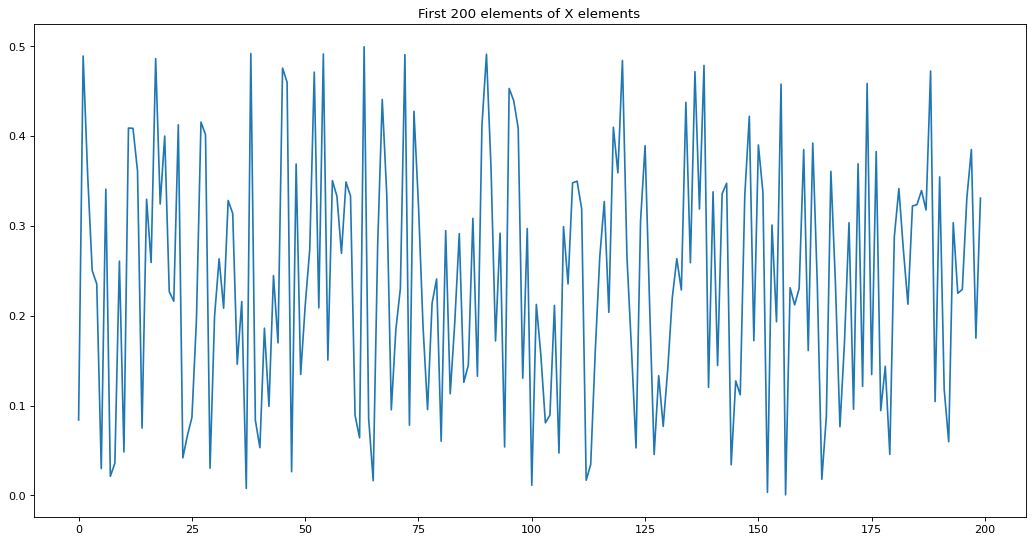

In [23]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of X elements")
plt.plot(NARMA10_X[:200])
plt.show()

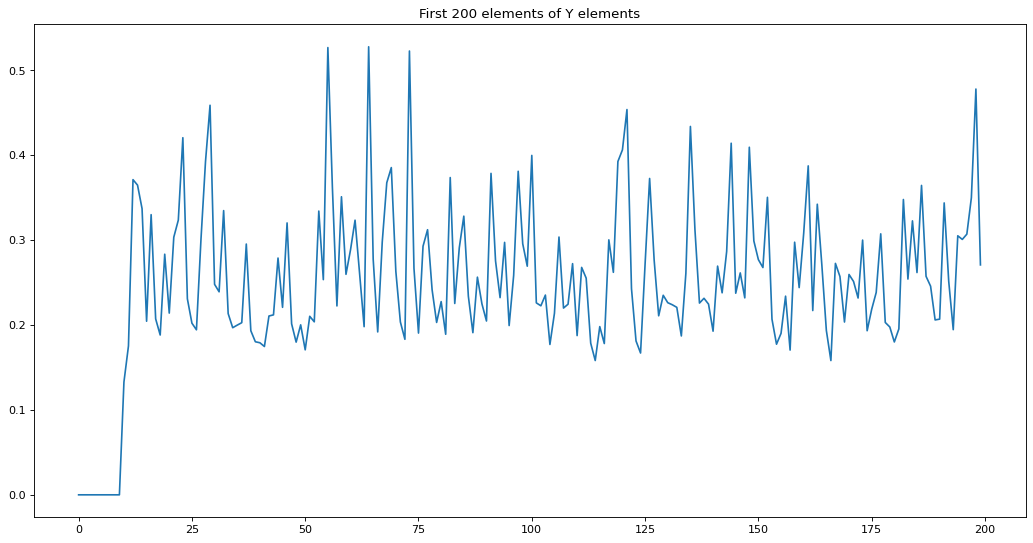

In [24]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of Y elements")
plt.plot(NARMA10_y[:200])
plt.show()

## TDNN

In [25]:
# train split
X_train = NARMA10_X[:4000]
y_train = NARMA10_y[:4000]

# valid split
X_valid = NARMA10_X[4000:5000]
y_valid = NARMA10_y[4000:5000]

Grid search for Time Delay Neural Network over NARMA10 dataset.
I will search over:
- number of delay's steps (window_size).
- number of hidden layers (hidden_layers).
- dimensionality of the hidden layers (hidden_dim).
- learning rate.
- number of epochs

In [26]:
grid = {
    "window_size" : [10, 30],
    "hidden_layers" : [1, 2],
    "hidden_dim" : [128, 256],
    "learning_rate" : [1e-3, 1e-2],
    "num_epochs" : [200]
}

train_losses, valid_losses, best_params = grid_search(model_compile_tdnn, one_step_train_loop_tdnn, grid, X_train, y_train, X_valid, y_valid)

100%|██████████| 200/200 [00:03<00:00, 65.11it/s] 


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.004551415331661701


100%|██████████| 200/200 [00:00<00:00, 627.52it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.004682180006057024


100%|██████████| 200/200 [00:00<00:00, 626.87it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0046732076443731785


100%|██████████| 200/200 [00:00<00:00, 625.10it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.005109216086566448


100%|██████████| 200/200 [00:00<00:00, 541.90it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.00467635365203023


100%|██████████| 200/200 [00:00<00:00, 542.67it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.004860805347561836


100%|██████████| 200/200 [00:00<00:00, 452.81it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.004970707930624485


100%|██████████| 200/200 [00:00<00:00, 520.31it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.004639687482267618


100%|██████████| 200/200 [00:00<00:00, 604.45it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0014319999609142542


100%|██████████| 200/200 [00:00<00:00, 596.32it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0008832421735860407


100%|██████████| 200/200 [00:00<00:00, 624.51it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.000846993294544518


100%|██████████| 200/200 [00:00<00:00, 627.84it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.001290832762606442


100%|██████████| 200/200 [00:00<00:00, 492.02it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0008001297828741372


100%|██████████| 200/200 [00:00<00:00, 409.05it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0005847678403370082


100%|██████████| 200/200 [00:00<00:00, 394.73it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0008213937981054187


100%|██████████| 200/200 [00:00<00:00, 392.74it/s]

 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0009893097449094057
finished grid search, the best are: {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} with a loss of:  0.0005847678403370082


In [27]:
NARMA10_TDNN_valid_loss = valid_losses[-1]

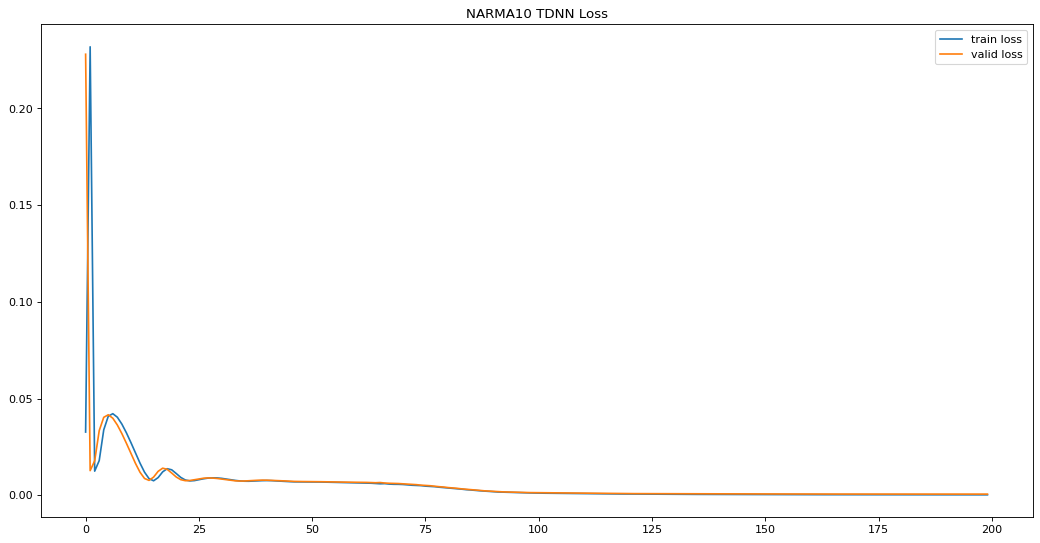

In [28]:
figure(figsize=(16, 8), dpi=80)
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()
plt.title("NARMA10 TDNN Loss")
plt.show()

In [29]:
# test split
X_test = NARMA10_X[5000:]
y_test = NARMA10_y[5000:]

# train split
X_train = NARMA10_X[:5000]
y_train = NARMA10_y[:5000]

In [30]:
best_params

{'window_size': 30,
 'hidden_layers': 2,
 'hidden_dim': 128,
 'learning_rate': 0.01,
 'num_epochs': 200}

In [31]:
train_losses, test_losses, model, optimizer = train(X_train, y_train, X_test, y_test, model_compile_tdnn, one_step_train_loop_tdnn, best_params)

100%|██████████| 200/200 [00:00<00:00, 416.63it/s]


In [32]:
# Save model, optimizer and losses into the disk
save_stuffs(model, best_params, optimizer, train_losses, test_losses, "Objects/NARMA10_TDNN")

In [33]:
# --- load the model
# model, optimizer, train_losses, test_losses = load_stuffs(model_compile_tdnn, "Objects/NARMA10_TDNN")
# model = model.to(DEVICE)

In [34]:
NARMA10_TDNN_train_loss = train_losses[-1]
NARMA10_TDNN_test_loss = test_losses[-1]

In [35]:
print("TDNN NARMA10 Losses")
print("-- MSE Train", NARMA10_TDNN_train_loss)
print("-- MSE Valid", NARMA10_TDNN_valid_loss)
print("-- MSE Test", NARMA10_TDNN_test_loss)

TDNN NARMA10 Losses
-- MSE Train 0.0003508772933855653
-- MSE Valid 0.0005847678403370082
-- MSE Test 0.00046655297046527267


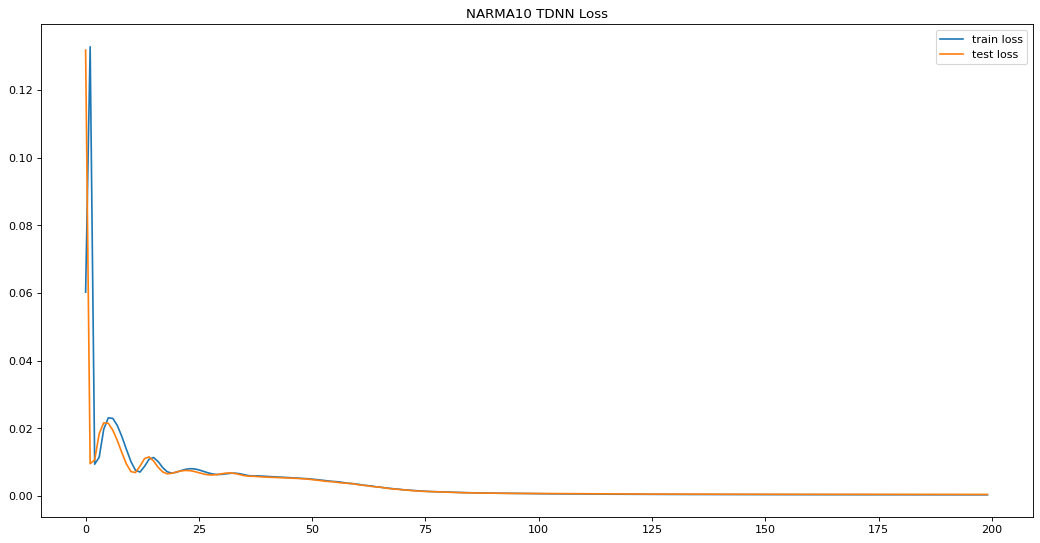

In [36]:
figure(figsize=(16, 8), dpi=80)
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.title("NARMA10 TDNN Loss")
plt.savefig("Images/NARMA10_TDNN_FinalTraining")
plt.show()

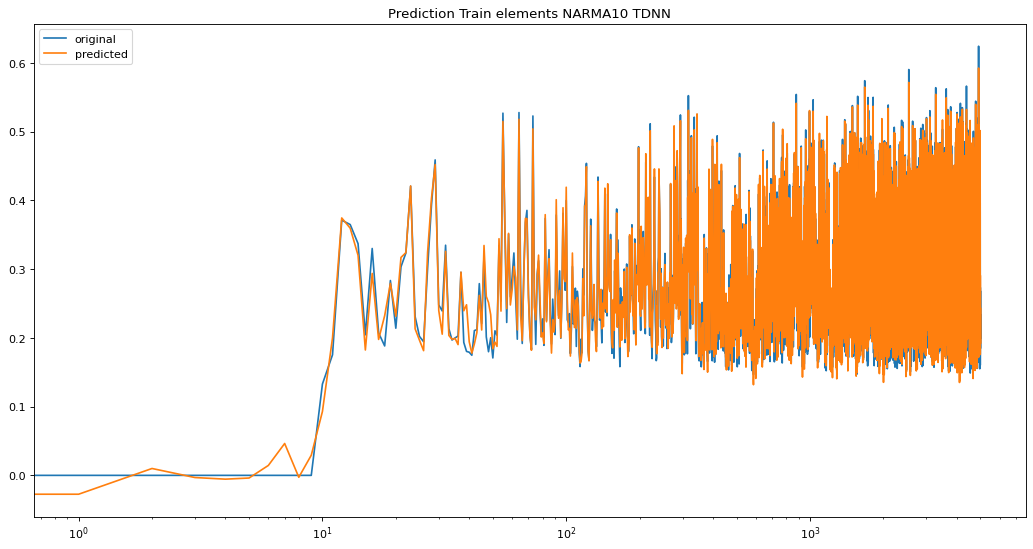

In [37]:
figure(figsize=(16, 8), dpi=80)
y_pred = predict(torch.Tensor(NARMA10_X), model)
plt.title("Prediction Train elements NARMA10 TDNN")
plt.semilogx(NARMA10_y[:5000], label="original")
plt.semilogx(y_pred[:5000].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/NARMA10_TDNN_Pred_train")
plt.show()

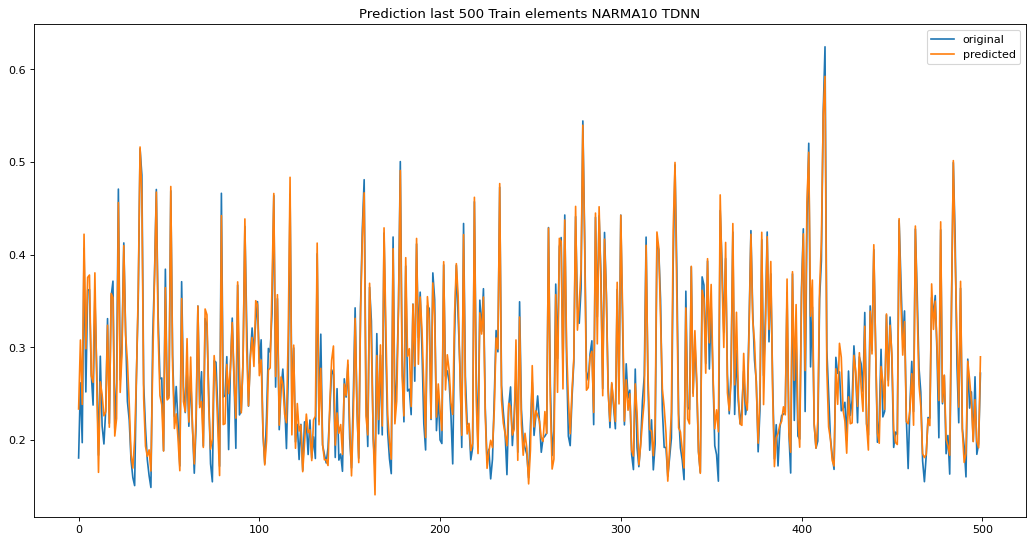

In [38]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction last 500 Train elements NARMA10 TDNN")
plt.plot(NARMA10_y[4500:5000], label="original")
plt.plot(y_pred[4500:5000].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/NARMA10_TDNN_Pred_train2")
plt.show()

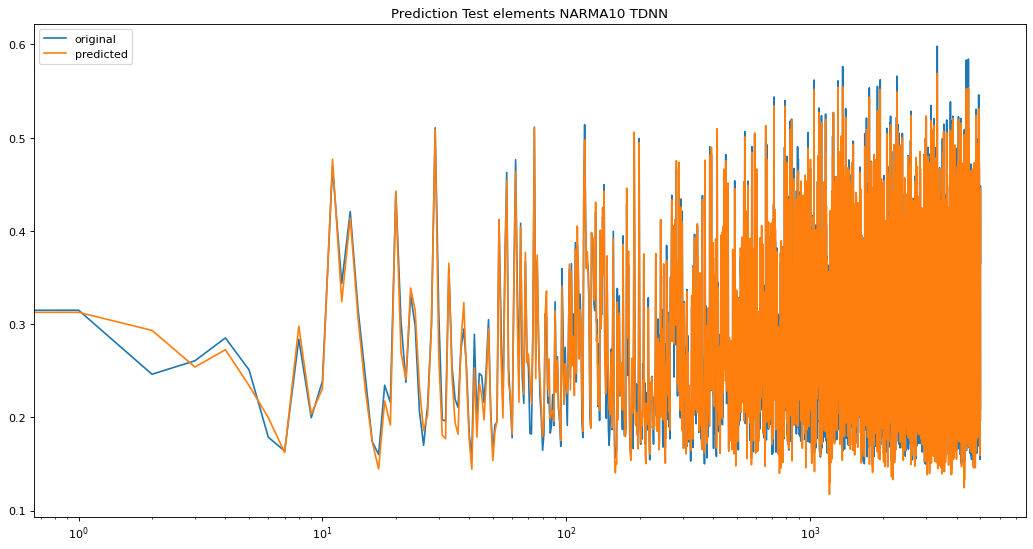

In [39]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction Test elements NARMA10 TDNN")
plt.semilogx(NARMA10_y[5000:], label="original")
plt.semilogx(y_pred[5000:].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/NARMA10_TDNN_Pred_test")
plt.show()

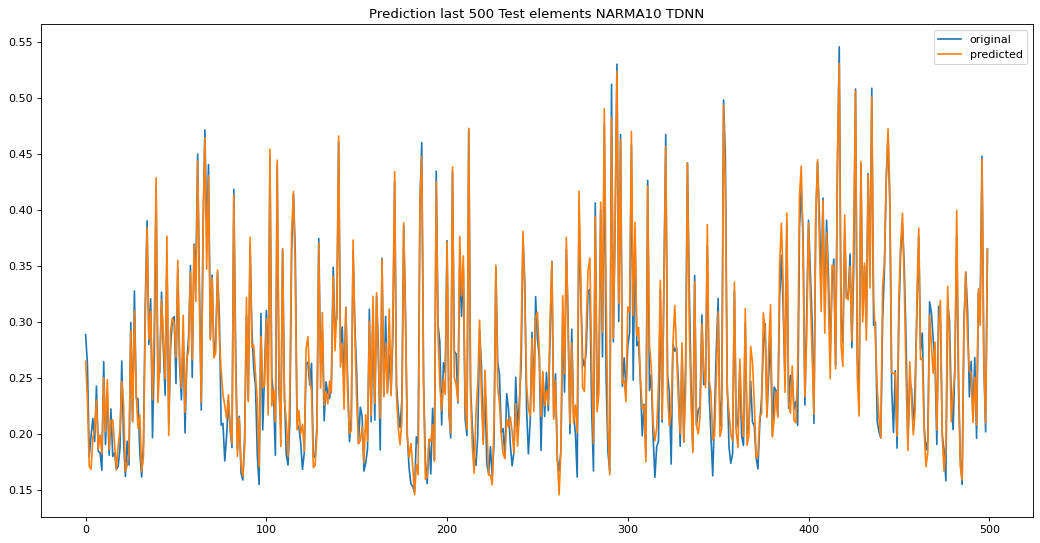

In [40]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction last 500 Test elements NARMA10 TDNN")
plt.plot(NARMA10_y[-500:], label="original")
plt.plot(y_pred[-500:].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/NARMA10_TDNN_Pred_test2")
plt.show()

## RNN

In [41]:
# train split
X_train = NARMA10_X[:4000]
y_train = NARMA10_y[:4000]

# valid split
X_valid = NARMA10_X[4000:5000]
y_valid = NARMA10_y[4000:5000]

Grid search for Recurrent Neural Network over NARMA10 dataset.
I will search over:
- number of hidden layers (hidden_layers).
- dimensionality of the hidden layers (hidden_dim).
- learning rate.
- number of epochs

In [42]:
grid = {
    "hidden_layers" : [1, 2, 3],
    "hidden_dim" : [128, 256],
    "learning_rate" : [1e-4, 1e-5],
    "num_epochs" : [200]
}

train_losses, valid_losses, best_params = grid_search(model_compile_rnn, one_step_train_loop_rnn, grid, X_train, y_train, X_valid, y_valid)

100%|██████████| 200/200 [00:03<00:00, 57.76it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.005667147692292929


100%|██████████| 200/200 [00:02<00:00, 81.01it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 1e-05, 'num_epochs': 200} loss 0.007656522560864687


100%|██████████| 200/200 [00:06<00:00, 31.45it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.004934460390359163


100%|██████████| 200/200 [00:06<00:00, 29.62it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 1e-05, 'num_epochs': 200} loss 0.006916331592947245


100%|██████████| 200/200 [00:03<00:00, 56.53it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.004557869862765074


100%|██████████| 200/200 [00:03<00:00, 61.46it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 1e-05, 'num_epochs': 200} loss 0.007186084054410458


100%|██████████| 200/200 [00:11<00:00, 17.30it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.003987815231084824


100%|██████████| 200/200 [00:11<00:00, 17.29it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 1e-05, 'num_epochs': 200} loss 0.007219715043902397


100%|██████████| 200/200 [00:04<00:00, 44.32it/s]


 -- finished {'hidden_layers': 3, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.004864799790084362


100%|██████████| 200/200 [00:04<00:00, 41.52it/s]


 -- finished {'hidden_layers': 3, 'hidden_dim': 128, 'learning_rate': 1e-05, 'num_epochs': 200} loss 0.007466783747076988


100%|██████████| 200/200 [00:16<00:00, 11.98it/s]


 -- finished {'hidden_layers': 3, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.0025703073479235172


100%|██████████| 200/200 [00:16<00:00, 11.89it/s]

 -- finished {'hidden_layers': 3, 'hidden_dim': 256, 'learning_rate': 1e-05, 'num_epochs': 200} loss 0.006994534283876419
finished grid search, the best are: {'hidden_layers': 3, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} with a loss of:  0.0025703073479235172


In [43]:
NARMA10_RNN_valid_loss = valid_losses[-1]

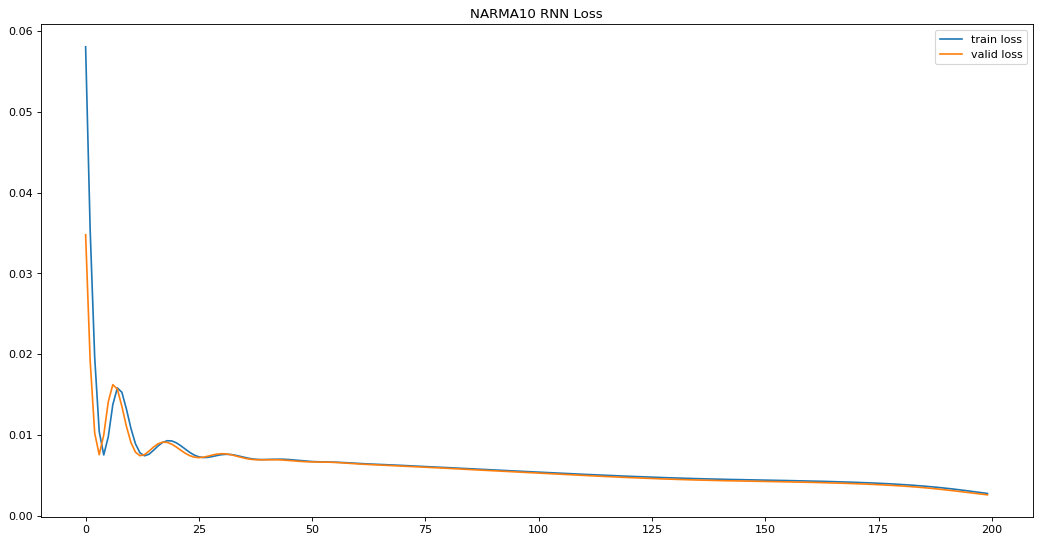

In [44]:
figure(figsize=(16, 8), dpi=80)
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()
plt.title("NARMA10 RNN Loss")
plt.show()

In [45]:
# test split
X_test = NARMA10_X[5000:]
y_test = NARMA10_y[5000:]

# train split
X_train = NARMA10_X[:5000]
y_train = NARMA10_y[:5000]

In [46]:
best_params

{'hidden_layers': 3,
 'hidden_dim': 256,
 'learning_rate': 0.0001,
 'num_epochs': 200}

In [47]:
train_losses, test_losses, model, optimizer = train(X_train, y_train, X_test, y_test, model_compile_rnn, one_step_train_loop_rnn, best_params)

100%|██████████| 200/200 [00:28<00:00,  7.05it/s]


In [48]:
# Save model, optimizer and losses into the disk
save_stuffs(model, best_params, optimizer, train_losses, test_losses, "Objects/NARMA10_RNN")

In [49]:
# --- load the model
# model, optimizer, train_losses, test_losses = load_stuffs(model_compile_rnn, "Objects/NARMA10_RNN")
# model = model.to(DEVICE)

In [50]:
NARMA10_RNN_train_loss = train_losses[-1]
NARMA10_RNN_test_loss = test_losses[-1]

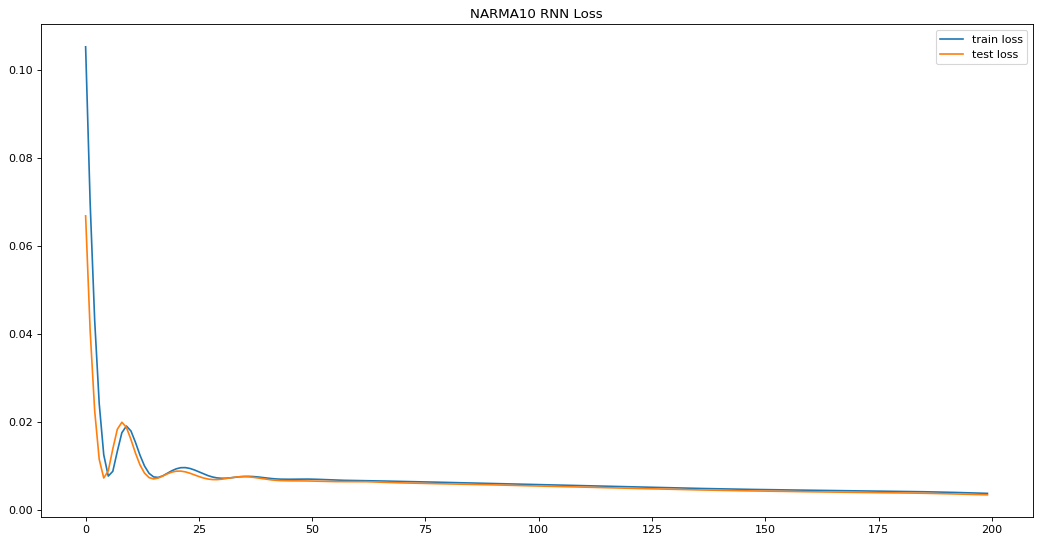

In [51]:
figure(figsize=(16, 8), dpi=80)
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.title("NARMA10 RNN Loss")
plt.savefig("Images/NARMA10_RNN_FinalTraining")
plt.show()

In [52]:
print("RNN NARMA10 Losses")
print("-- MSE Train", NARMA10_RNN_train_loss)
print("-- MSE Valid", NARMA10_RNN_valid_loss)
print("-- MSE Test", NARMA10_RNN_test_loss)

RNN NARMA10 Losses
-- MSE Train 0.0037365981843322515
-- MSE Valid 0.0025703073479235172
-- MSE Test 0.00340788415633142


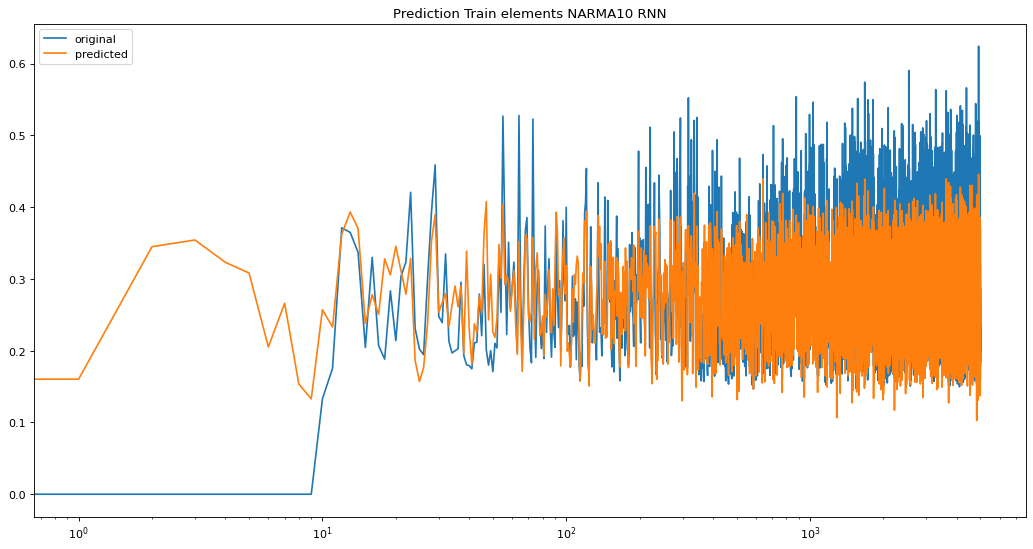

In [53]:
figure(figsize=(16, 8), dpi=80)
y_pred, _ = predict(torch.Tensor(NARMA10_X), model)
plt.semilogx(NARMA10_y[:5000], label="original")
plt.semilogx(y_pred[:5000].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.title("Prediction Train elements NARMA10 RNN")
plt.savefig("Images/NARMA10_RNN_Pred_train")
plt.show()

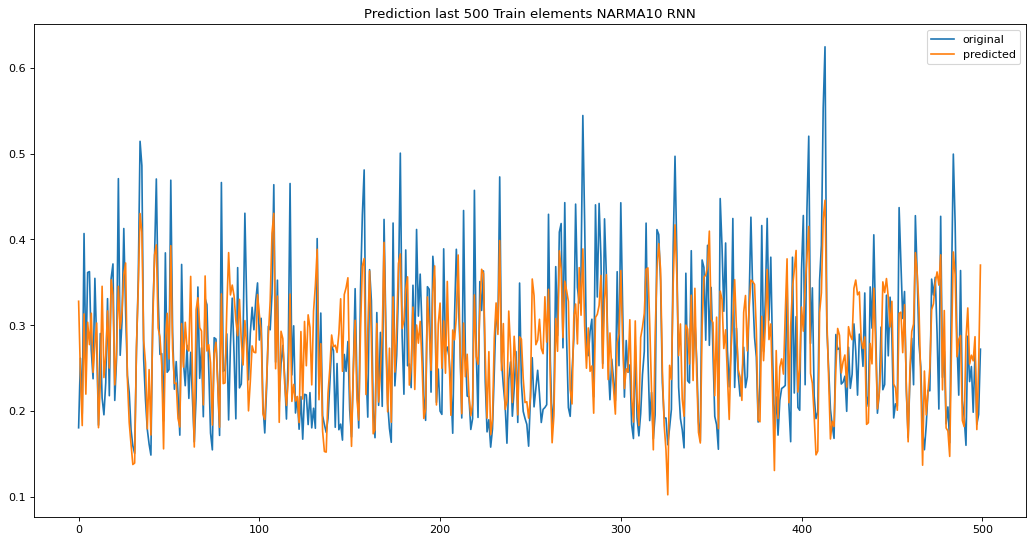

In [54]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction last 500 Train elements NARMA10 RNN")
plt.plot(NARMA10_y[4500:5000], label="original")
plt.plot(y_pred[4500:5000].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/NARMA10_RNN_Pred_train2")
plt.show()

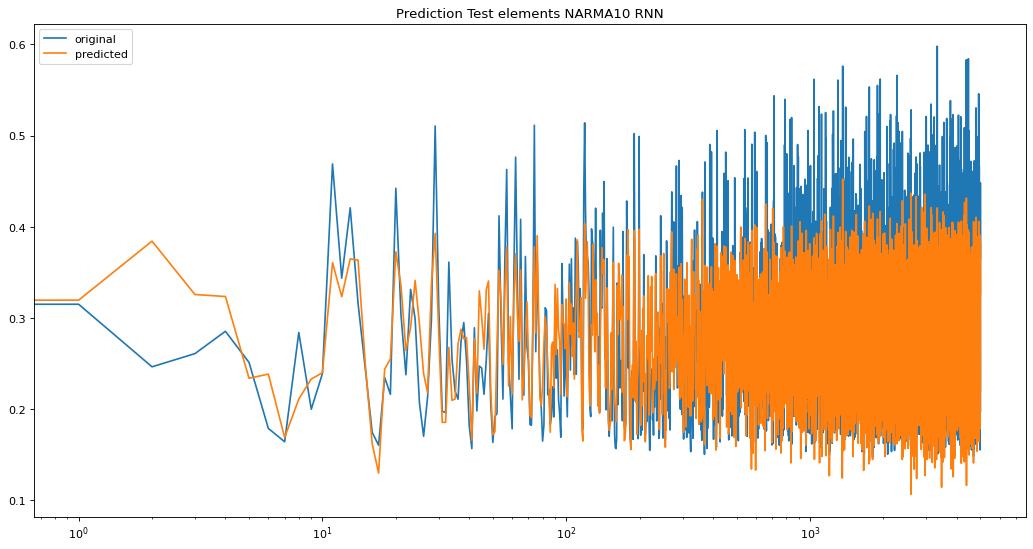

In [55]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction Test elements NARMA10 RNN")
plt.semilogx(NARMA10_y[5000:], label="original")
plt.semilogx(y_pred[5000:].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/NARMA10_RNN_Pred_test")
plt.show()

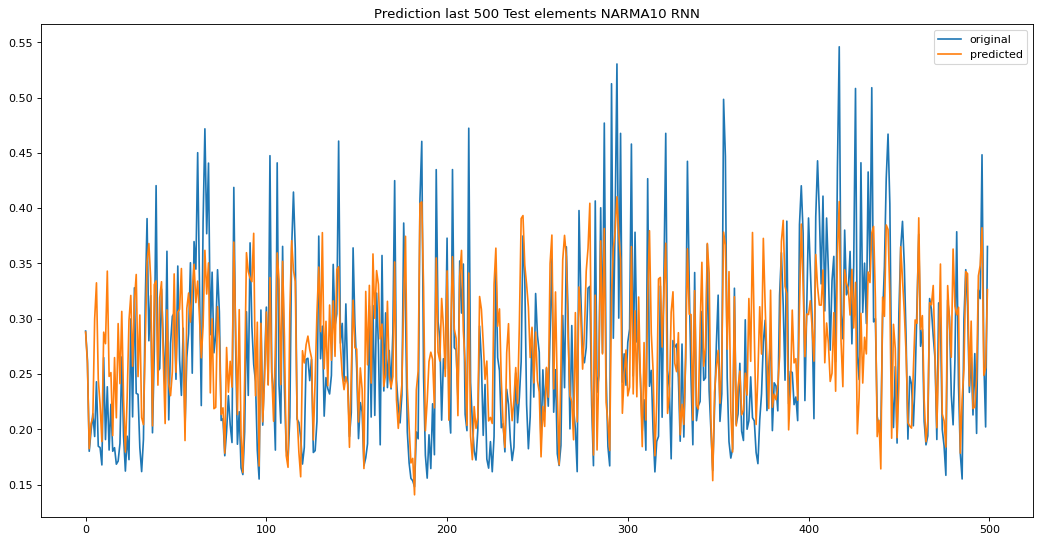

In [56]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction last 500 Test elements NARMA10 RNN")
plt.plot(NARMA10_y[-500:], label="original")
plt.plot(y_pred[-500:].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/NARMA10_RNN_Pred_test2")
plt.show()

# MG17

In [57]:
data_mg17 = pd.read_csv("data/MG17.csv", header=None)

In [58]:
data_mg17.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.032164,0.040426,0.057861,0.084015,0.11544,0.14572,0.16758,0.17624,0.17107,0.15465,...,-0.43905,-0.43957,-0.42772,-0.40213,-0.36305,-0.31286,-0.25555,-0.19556,-0.1368,-0.082192


In [59]:
data = data_mg17.values[0, :]

MG17_X = torch.Tensor(data[:-1])
MG17_y = torch.Tensor(data[1:])

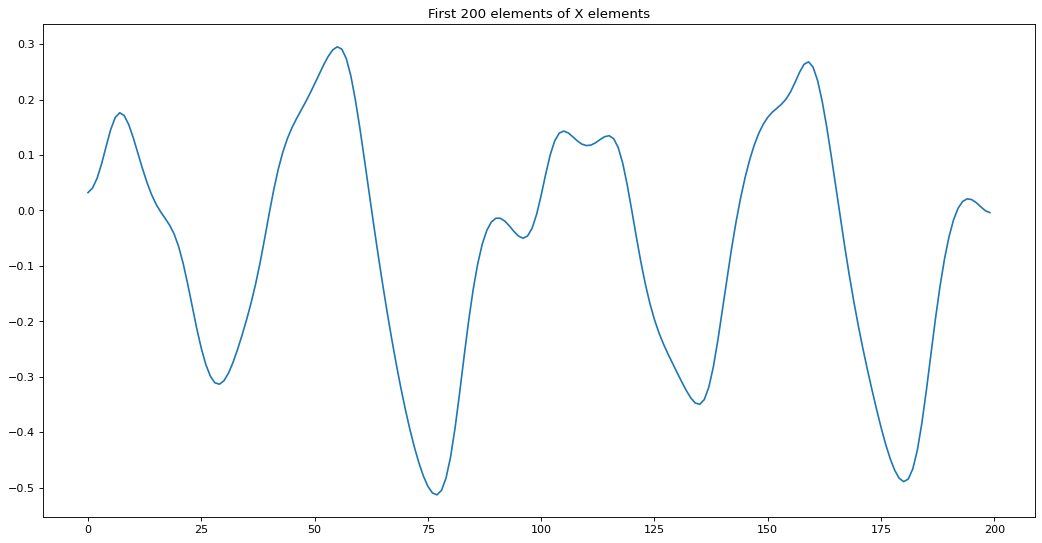

In [60]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of X elements")
plt.plot(MG17_X[:200])
plt.show()

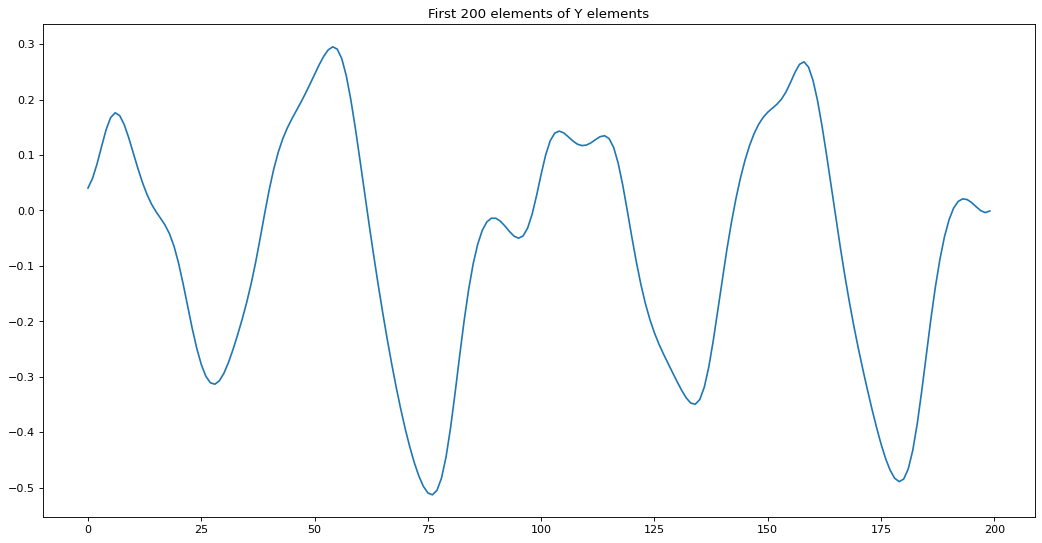

In [61]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of Y elements")
plt.plot(MG17_y[:200])
plt.show()

## TDNN

In [62]:
# train split
X_train = MG17_X[:4000]
y_train = MG17_y[:4000]

# valid split
X_valid = MG17_X[4000:5000]
y_valid = MG17_y[4000:5000]

Grid search for Time Delay Neural Network over NARMA10 dataset.
I will search over:
- number of delay's steps (window_size).
- number of hidden layers (hidden_layers).
- dimensionality of the hidden layers (hidden_dim).
- learning rate.
- number of epochs

In [63]:
grid = {
    "window_size" : [10, 30],
    "hidden_layers" : [1, 2],
    "hidden_dim" : [128, 256],
    "learning_rate" : [1e-3, 1e-2],
    "num_epochs" : [200]
}

train_losses, valid_losses, best_params = grid_search(model_compile_tdnn, one_step_train_loop_tdnn, grid, X_train, y_train, X_valid, y_valid)

100%|██████████| 200/200 [00:00<00:00, 606.61it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0008811759180389345


100%|██████████| 200/200 [00:00<00:00, 607.18it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.00019350607180967927


100%|██████████| 200/200 [00:00<00:00, 580.71it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0005560095305554569


100%|██████████| 200/200 [00:00<00:00, 559.98it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.00019782154413405806


100%|██████████| 200/200 [00:00<00:00, 514.25it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.00023979485558811575


100%|██████████| 200/200 [00:00<00:00, 504.29it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 9.464813047088683e-05


100%|██████████| 200/200 [00:00<00:00, 467.17it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.00023362452338915318


100%|██████████| 200/200 [00:00<00:00, 489.78it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0001300136500503868


100%|██████████| 200/200 [00:00<00:00, 590.69it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0003861629811581224


100%|██████████| 200/200 [00:00<00:00, 469.89it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.00036008041934110224


100%|██████████| 200/200 [00:00<00:00, 465.95it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0004095747717656195


100%|██████████| 200/200 [00:00<00:00, 481.89it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0003013817477039993


100%|██████████| 200/200 [00:00<00:00, 376.80it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.00043682297109626234


100%|██████████| 200/200 [00:00<00:00, 382.43it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0002866397553589195


100%|██████████| 200/200 [00:00<00:00, 437.27it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0003093860868830234


100%|██████████| 200/200 [00:00<00:00, 509.53it/s]

 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.00031211585155688226
finished grid search, the best are: {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} with a loss of:  9.464813047088683e-05


In [64]:
MG17_TDNN_valid_loss = valid_losses[-1]

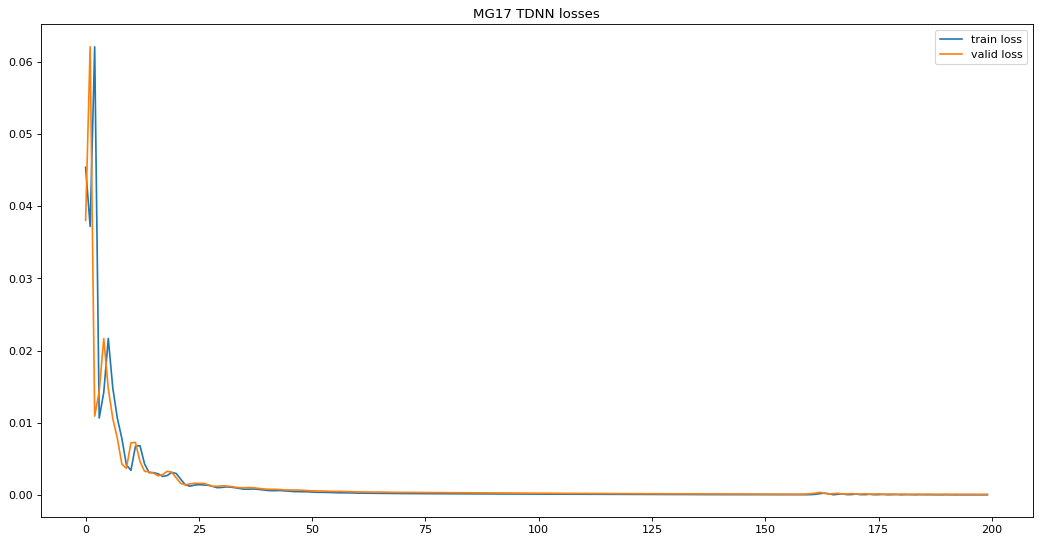

In [65]:
figure(figsize=(16, 8), dpi=80)
plt.title("MG17 TDNN losses")
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()
plt.show()

In [66]:
# test split
X_test = MG17_X[5000:]
y_test = MG17_y[5000:]

# train split
X_train = MG17_X[:5000]
y_train = MG17_y[:5000]

In [67]:
best_params

{'window_size': 10,
 'hidden_layers': 2,
 'hidden_dim': 128,
 'learning_rate': 0.01,
 'num_epochs': 200}

In [68]:
train_losses, test_losses, model, optimizer = train(X_train, y_train, X_test, y_test, model_compile_tdnn, one_step_train_loop_tdnn, best_params)

100%|██████████| 200/200 [00:00<00:00, 483.87it/s]


In [69]:
# Save model, optimizer and losses into the disk
save_stuffs(model, best_params, optimizer, train_losses, test_losses, "Objects/MG17_TDNN")

In [70]:
# --- load the model
# model, optimizer, train_losses, test_losses = load_stuffs(model_compile_tdnn, "Objects/MG17_TDNN")
# model = model.to(DEVICE)

In [71]:
MG17_TDNN_train_loss = train_losses[-1]
MG17_TDNN_test_loss = test_losses[-1]

In [72]:
print("TDNN MG17 Losses")
print("-- MSE Train", MG17_TDNN_train_loss)
print("-- MSE Valid", MG17_TDNN_valid_loss)
print("-- MSE Test", MG17_TDNN_test_loss)

TDNN MG17 Losses
-- MSE Train 2.092745853587985e-05
-- MSE Valid 9.464813047088683e-05
-- MSE Test 1.9278726540505886e-05


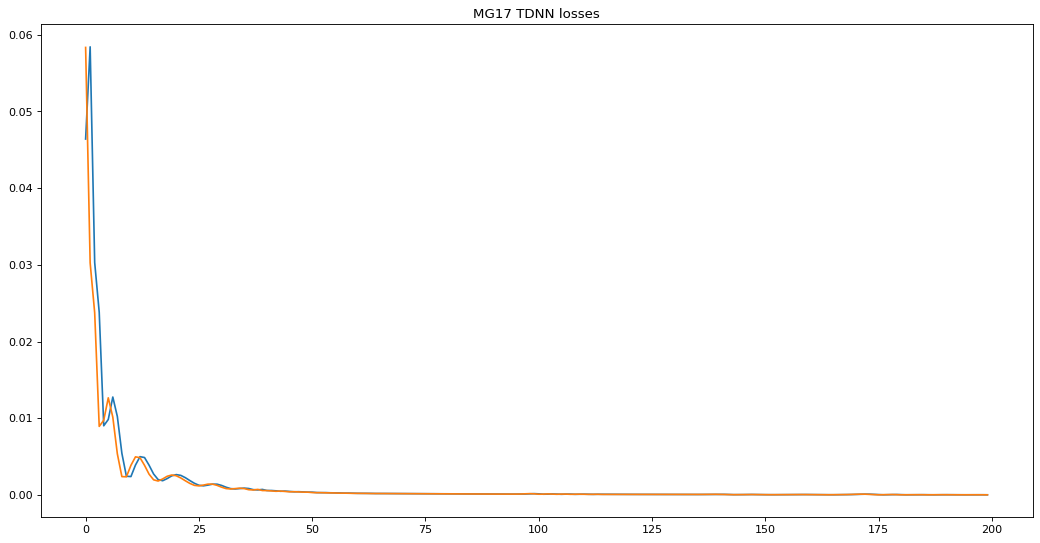

In [73]:
figure(figsize=(16, 8), dpi=80)
plt.title("MG17 TDNN losses")
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.savefig("Images/MG17_TDNN_FinalTraining")
plt.show()

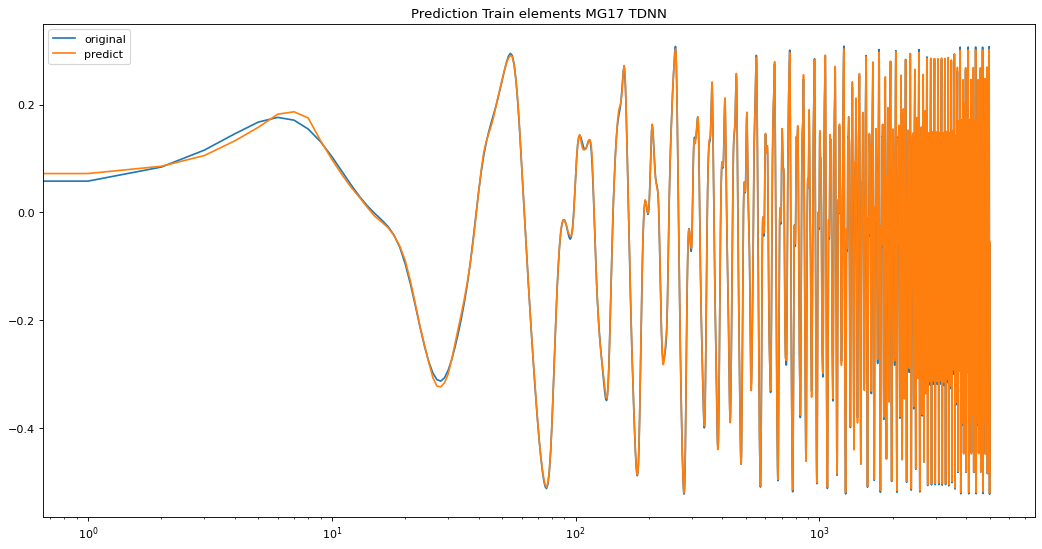

In [74]:
figure(figsize=(16, 8), dpi=80)
y_pred = predict(torch.Tensor(MG17_X), model)
plt.semilogx(MG17_y[:5000], label="original")
plt.semilogx(y_pred[:5000].view(-1).detach().to("cpu"), label="predict")
plt.title("Prediction Train elements MG17 TDNN")
plt.legend()
plt.savefig("Images/MG17_TDNN_Pred_train")
plt.show()

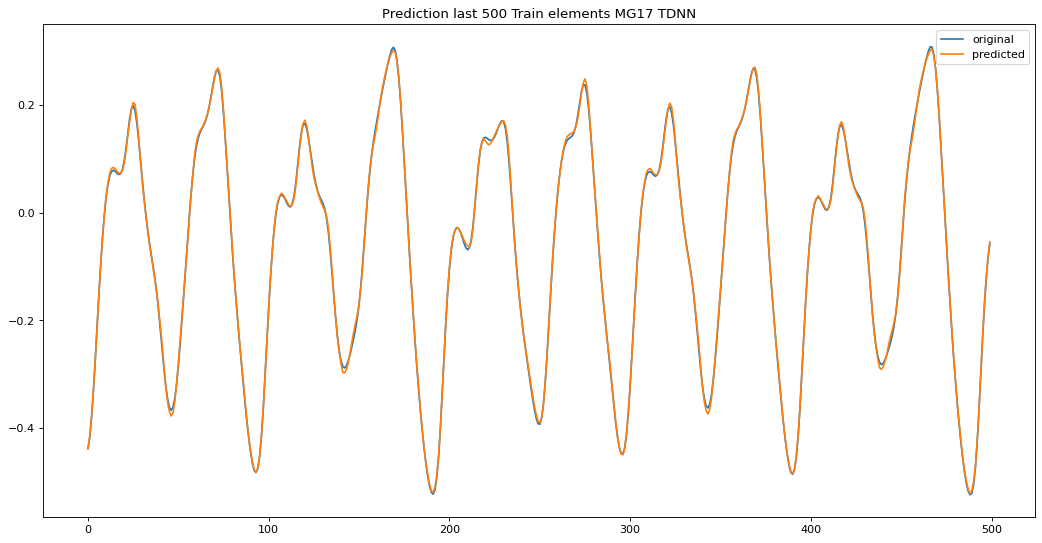

In [75]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction last 500 Train elements MG17 TDNN")
plt.plot(MG17_y[4500:5000], label="original")
plt.plot(y_pred[4500:5000].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/MG17_TDNN_Pred_train2")
plt.show()

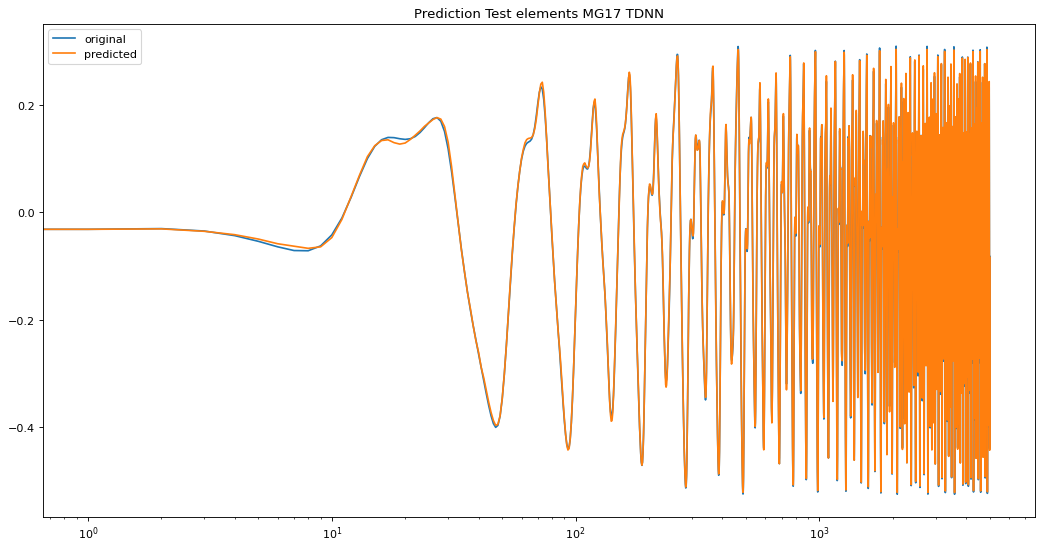

In [76]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction Test elements MG17 TDNN")
plt.semilogx(MG17_y[5000:], label="original")
plt.semilogx(y_pred[5000:].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/MG17_TDNN_Pred_test")
plt.show()

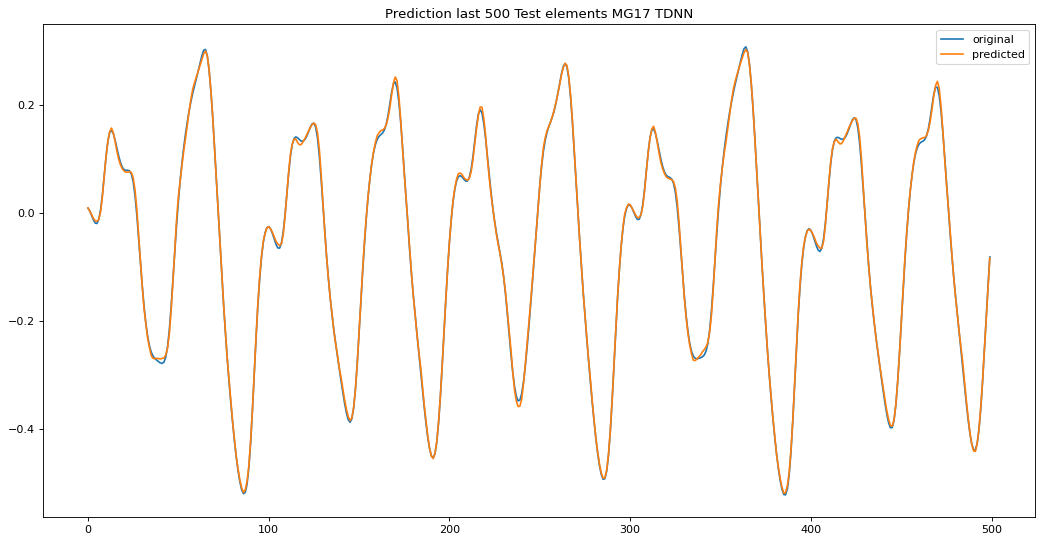

In [77]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction last 500 Test elements MG17 TDNN")
plt.plot(MG17_y[-500:], label="original")
plt.plot(y_pred[-500:].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/MG17_TDNN_Pred_test2")
plt.show()

## RNN

In [78]:
# train split
X_train = MG17_X[:4000]
y_train = MG17_y[:4000]

# valid split
X_valid = MG17_X[4000:5000]
y_valid = MG17_y[4000:5000]

Grid search for Recurrent Neural Network over MG17 dataset.
I will search over:
- number of hidden layers (hidden_layers).
- dimensionality of the hidden layers (hidden_dim).
- learning rate.
- number of epochs

In [79]:
grid = {
    "hidden_layers" : [1, 2, 4],
    "hidden_dim" : [128, 256],
    "learning_rate" : [1e-3, 1e-4],
    "num_epochs" : [200]
}

train_losses, valid_losses, best_params = grid_search(model_compile_rnn, one_step_train_loop_rnn, grid, X_train, y_train, X_valid, y_valid)

100%|██████████| 200/200 [00:02<00:00, 80.94it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.00022199988598003983


100%|██████████| 200/200 [00:02<00:00, 84.75it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.0027682941872626543


100%|██████████| 200/200 [00:06<00:00, 31.18it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.00014475987700279802


100%|██████████| 200/200 [00:06<00:00, 32.47it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.0009650493157096207


100%|██████████| 200/200 [00:03<00:00, 51.25it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.00010271253268001601


100%|██████████| 200/200 [00:03<00:00, 60.30it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.0007926503894850612


100%|██████████| 200/200 [00:11<00:00, 17.34it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 7.471923890989274e-05


100%|██████████| 200/200 [00:11<00:00, 17.36it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.0006191467400640249


100%|██████████| 200/200 [00:05<00:00, 34.76it/s]


 -- finished {'hidden_layers': 4, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 6.280752131715417e-05


100%|██████████| 200/200 [00:06<00:00, 33.17it/s]


 -- finished {'hidden_layers': 4, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.0005165295442566276


100%|██████████| 200/200 [00:22<00:00,  9.00it/s]


 -- finished {'hidden_layers': 4, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 4.2480700358282775e-05


100%|██████████| 200/200 [00:22<00:00,  9.00it/s]

 -- finished {'hidden_layers': 4, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.0002251313126180321
finished grid search, the best are: {'hidden_layers': 4, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} with a loss of:  4.2480700358282775e-05


In [80]:
MG17_RNN_valid_loss = valid_losses[-1]

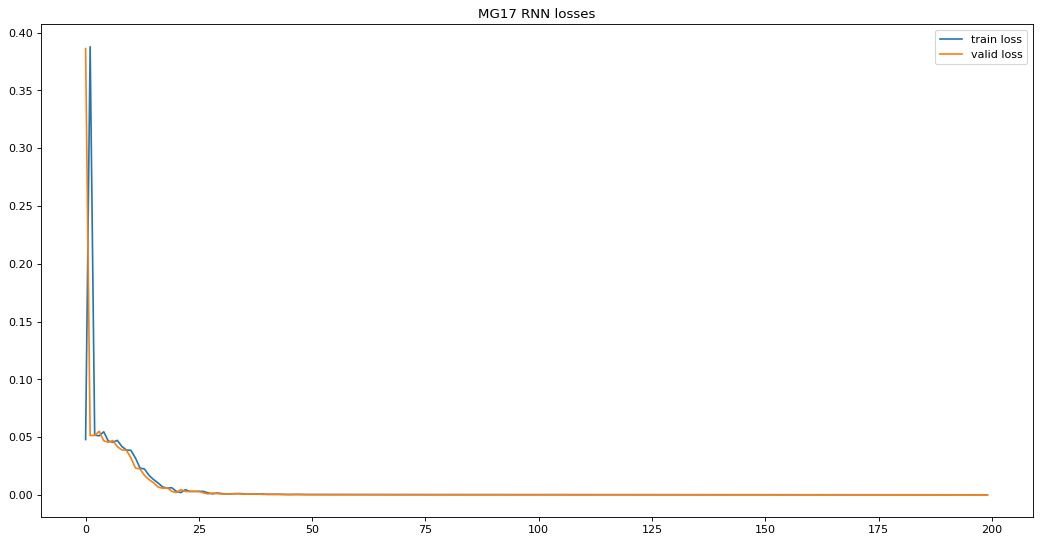

In [81]:
figure(figsize=(16, 8), dpi=80)
plt.title("MG17 RNN losses")
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()
plt.show()

In [82]:
# test split
X_test = MG17_X[5000:]
y_test = MG17_y[5000:]

# train split
X_train = MG17_X[:5000]
y_train = MG17_y[:5000]

In [83]:
train_losses, test_losses, model, optimizer = train(X_train, y_train, X_test, y_test, model_compile_rnn, one_step_train_loop_rnn, best_params)

100%|██████████| 200/200 [00:37<00:00,  5.39it/s]


In [84]:
# Save model, optimizer and losses into the disk
save_stuffs(model, best_params, optimizer, train_losses, test_losses, "Objects/MG17_RNN")

In [85]:
# --- load the model
# model, optimizer, train_losses, test_losses = load_stuffs(model_compile_rnn, "Objects/MG17_RNN")
# model = model.to(DEVICE)

In [86]:
MG17_RNN_train_loss = train_losses[-1]
MG17_RNN_test_loss = test_losses[-1]

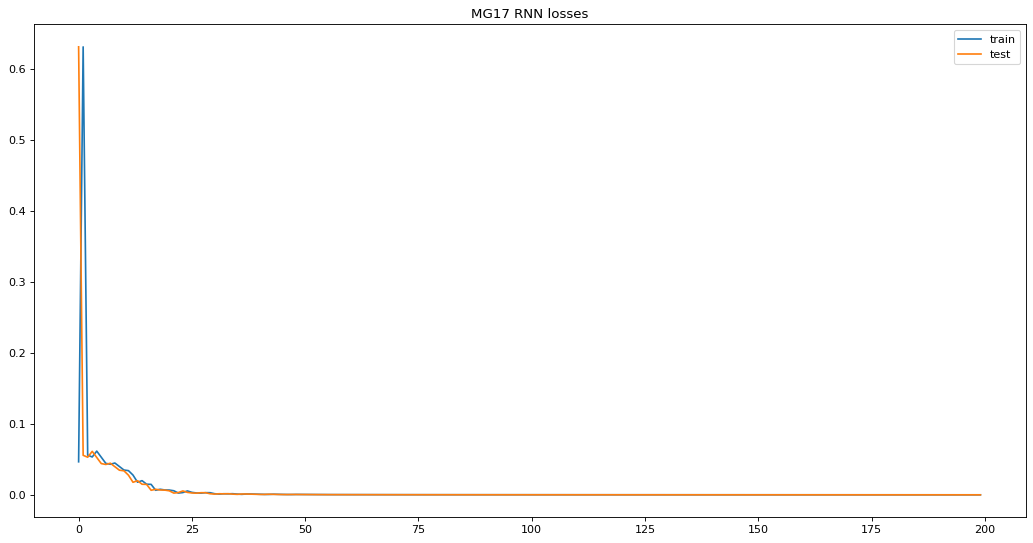

<Figure size 640x480 with 0 Axes>

In [87]:
figure(figsize=(16, 8), dpi=80)
plt.title("MG17 RNN losses")
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.show()
plt.savefig("Images/MG17_RNN_FinalTraining")

In [88]:
print("TDNN MG17 Losses")
print("-- MSE Train", MG17_RNN_train_loss)
print("-- MSE Valid", MG17_RNN_valid_loss)
print("-- MSE Test", MG17_RNN_test_loss)

TDNN MG17 Losses
-- MSE Train 6.330192991299555e-05
-- MSE Valid 4.2480700358282775e-05
-- MSE Test 5.8289599110139534e-05


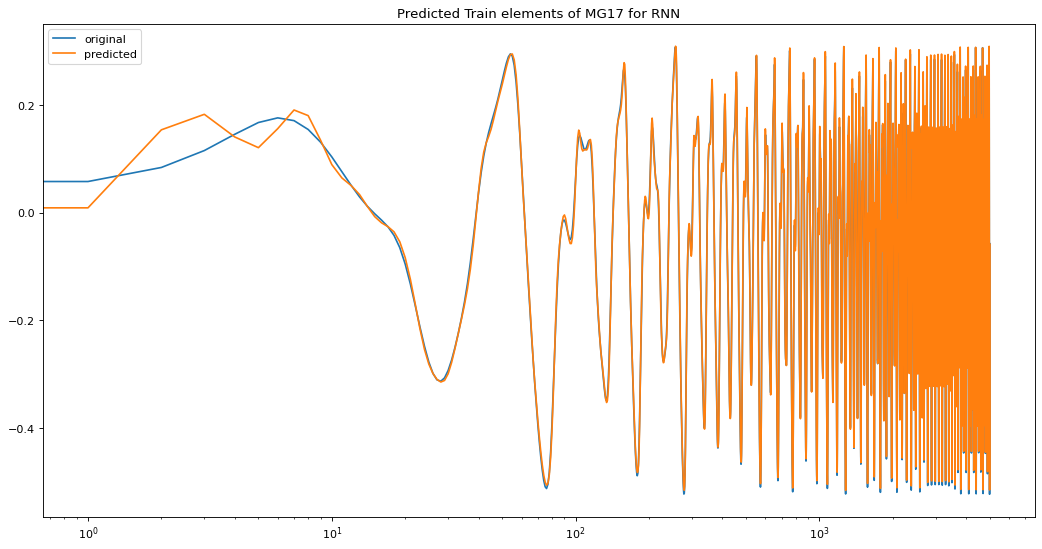

In [89]:
figure(figsize=(16, 8), dpi=80)
y_pred, _ = predict(torch.Tensor(MG17_X), model)
plt.title("Predicted Train elements of MG17 for RNN")
plt.semilogx(MG17_y[:5000], label="original")
plt.semilogx(y_pred[:5000].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/MG17_RNN_Pred_train")
plt.show()

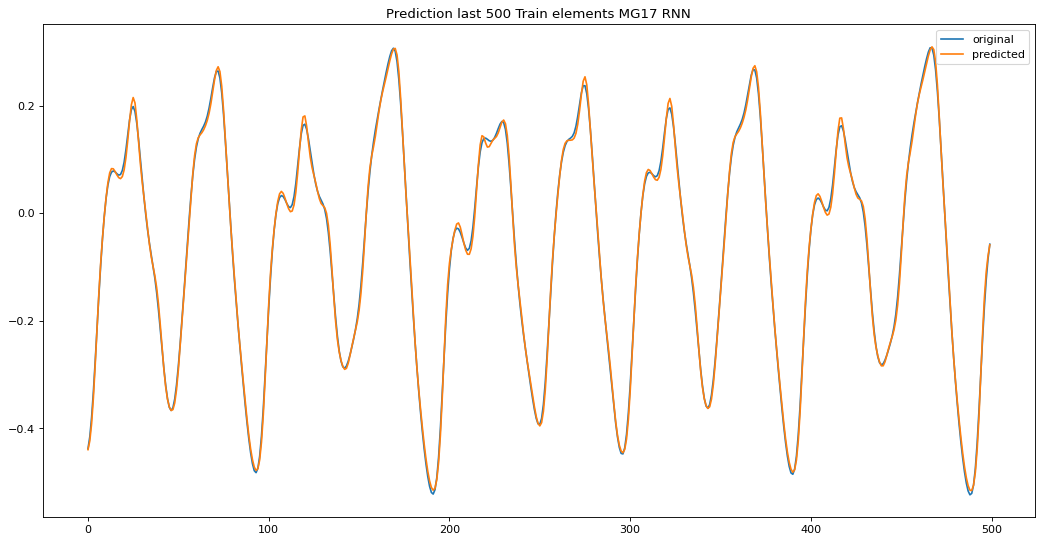

In [90]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction last 500 Train elements MG17 RNN")
plt.plot(MG17_y[4500:5000], label="original")
plt.plot(y_pred[4500:5000].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/MG17_RNN_Pred_train2")
plt.show()

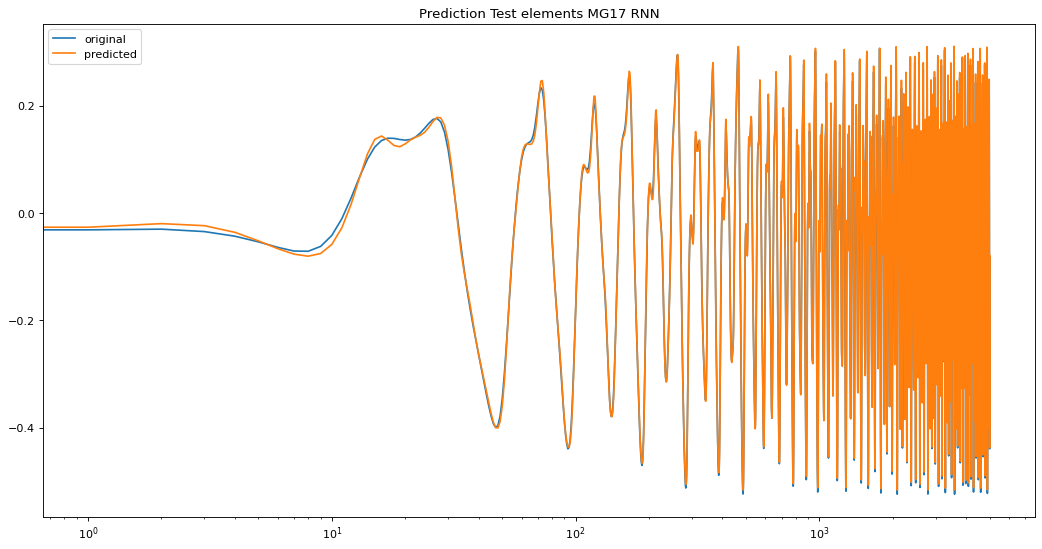

In [91]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction Test elements MG17 RNN")
plt.semilogx(MG17_y[5000:], label="original")
plt.semilogx(y_pred[5000:].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/MG17_RNN_Pred_test")
plt.show()

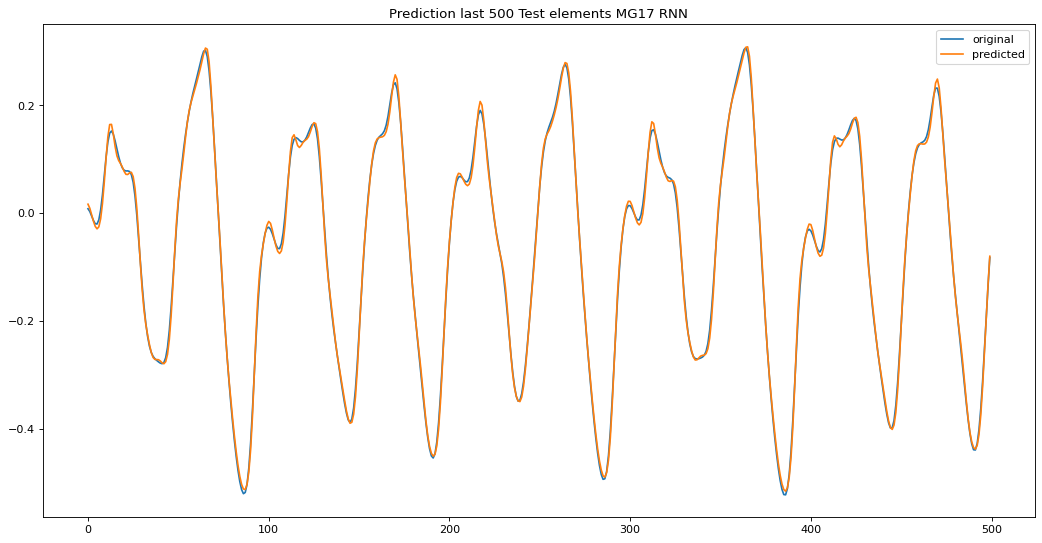

In [92]:
figure(figsize=(16, 8), dpi=80)
plt.title("Prediction last 500 Test elements MG17 RNN")
plt.plot(MG17_y[-500:], label="original")
plt.plot(y_pred[-500:].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/MG17_RNN_Pred_test2")
plt.show()

In [93]:
# zip the folders and download the data

!zip -r Images.zip Images/ 
!zip -r Objects.zip Objects/ 

  adding: Images/ (stored 0%)
  adding: Images/NARMA10_TDNN_Pred_test.png (deflated 4%)
  adding: Images/MG17_TDNN_Pred_train2.png (deflated 4%)
  adding: Images/NARMA10_RNN_FinalTraining.png (deflated 17%)
  adding: Images/MG17_RNN_Pred_test.png (deflated 4%)
  adding: Images/MG17_RNN_Pred_test2.png (deflated 4%)
  adding: Images/NARMA10_RNN_Pred_test.png (deflated 4%)
  adding: Images/NARMA10_TDNN_Pred_train2.png (deflated 4%)
  adding: Images/NARMA10_TDNN_Pred_train.png (deflated 5%)
  adding: Images/MG17_TDNN_FinalTraining.png (deflated 18%)
  adding: Images/NARMA10_TDNN_Pred_test2.png (deflated 4%)
  adding: Images/NARMA10_RNN_Pred_test2.png (deflated 3%)
  adding: Images/MG17_RNN_Pred_train2.png (deflated 4%)
  adding: Images/MG17_TDNN_Pred_test2.png (deflated 4%)
  adding: Images/NARMA10_TDNN_FinalTraining.png (deflated 19%)
  adding: Images/MG17_RNN_FinalTraining.png (deflated 90%)
  adding: Images/NARMA10_RNN_Pred_train.png (deflated 5%)
  adding: Images/MG17_TDNN_Pred_train.p